## Lab Lecture 6: Analysis of the population receiving Food Stamps
#### Idea from Kamsey Agu, this was part of her CE 263N_Final Project 

In [1]:
#You will need:
!pip install geopandas==0.8.2
!pip install contextily
!pip install cenpy

  Using cached geopandas-0.8.2-py2.py3-none-any.whl (962 kB)
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.10.2
    Uninstalling geopandas-0.10.2:
      Successfully uninstalled geopandas-0.10.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-mobility 1.3.1 requires geopandas<0.11.0,>=0.10.2, but you have geopandas 0.8.2 which is incompatible.
osmnx 1.1.1 requires geopandas>=0.9, but you have geopandas 0.8.2 which is incompatible.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import contextily
import geopandas
import cenpy
%matplotlib inline
acs = cenpy.products.ACS(2017)

In [4]:
vars_to_download = {
    "B02001_002E": "total_pop_white",     # Total white population
    "B02001_003E": "total_pop_black",     #Total black population
    "B01003_001E": "total_pop",           # Total population
    "B09019_001E": "hh_total",            # Total households
    "B15003_002E": "total_no_bachelor",      # Total w/o Bachelor degree
    "B01002_001E": "median_age",          # Median age
    "B19013_001E": "median_hh_income",     # Median household income 
    "B19058_001E": "SNAP_hh",              # Households receiving Food Stamps/SNAP 
    "B08015_001E": "access_to_vehicle"   # Workers over age 16 that drove alone to work by car, van, truck
}
vars_to_download_l = list(vars_to_download.keys())

http://cenpy-devs.github.io/cenpy/generated/cenpy.products.ACS.html

<image src="cenpy_methods.jpg"/>

Note that we can add data from county, place, metropolitan statistical area.

Source: http://cenpy-devs.github.io/cenpy/generated/cenpy.products.ACS.html

In [5]:
# Extracting census variables from Fulton County, GA
db = acs.from_county("Fulton, GA",
                  level="tract",
                  variables=vars_to_download_l
                 )

/Users/marta/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/marta/opt/anaconda3/lib/python3.9/site-packages/geopandas/_vectorized.py:143: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


In [311]:
db.head()

,GEOID,geometry,B01002_001E,B01003_001E,B02001_002E,B02001_003E,B08015_001E,B09019_001E,B15003_002E,B19013_001E,B19058_001E,NAME,state,county,tract
0,13121010400,"POLYGON ((-9445524.810 3963415.140, -9445427.0...",37.5,8290.0,3877.0,3970.0,2815.0,8290.0,107.0,50294.0,2662.0,"Census Tract 104, Fulton County, Georgia",13,121,010400
1,13121010512,"POLYGON ((-9412223.140 3972373.180, -9412195.5...",28.3,6497.0,240.0,6061.0,2235.0,6497.0,15.0,30819.0,2472.0,"Census Tract 105.12, Fulton County, Georgia",13,121,010512
2,13121010604,"POLYGON ((-9405103.470 3978853.000, -9405100.5...",35.3,2898.0,263.0,2342.0,990.0,2898.0,12.0,33133.0,1297.0,"Census Tract 106.04, Fulton County, Georgia",13,121,010604
3,13121008301,"POLYGON ((-9403317.910 3997890.800, -9403309.2...",40.3,2556.0,58.0,2487.0,505.0,2556.0,55.0,27023.0,927.0,"Census Tract 83.01, Fulton County, Georgia",13,121,008301
4,13121008102,"POLYGON ((-9406459.460 3995383.140, -9406444.4...",37.8,6876.0,193.0,6353.0,1395.0,6876.0,42.0,24940.0,2693.0,"Census Tract 81.02, Fulton County, Georgia",13,121,008102


In [306]:
len(db)

204

In [312]:
var_names = acs.variables\
               .reindex(vars_to_download)\
               [["label", "concept"]]\
               .reset_index()\
               .rename(columns={"index": "var_id"})
var_names["short_name"] = var_names["var_id"].map(vars_to_download)

In [308]:
## Option Droping NA
#db.loc[:, vars_to_download].dropna(axis=0)

In [313]:
filler = lambda col: col.fillna(col.mean())
db.loc[:, vars_to_download] = db.loc[:, vars_to_download]\
                                .apply(filler)

In [314]:
db = db.rename(columns=vars_to_download)

In [315]:
db["area_sqkm"] = db.to_crs(epsg=5070).area / 1e6

In [316]:
db["pct_no_bachelor"] = db["total_no_bachelor"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

In [317]:
db["pct_black"] = db["total_pop_black"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

In [318]:
db["pct_white"] = db["total_pop_white"] / \
                  (db["total_pop"] + \
                   (db["total_pop"]==0) * 1
                  )

In [319]:
db["pct_SNAP"] = db["SNAP_hh"] / \
                  (db["hh_total"] + \
                   (db["hh_total"]==0) * 1
                  )

In [320]:
db.head()

,GEOID,geometry,median_age,total_pop,total_pop_white,total_pop_black,access_to_vehicle,hh_total,total_no_bachelor,median_hh_income,SNAP_hh,NAME,state,county,tract,area_sqkm,pct_no_bachelor,pct_black,pct_white,pct_SNAP
0,13121010400,"POLYGON ((-9445524.810 3963415.140, -9445427.0...",37.5,8290.0,3877.0,3970.0,2815.0,8290.0,107.0,50294.0,2662.0,"Census Tract 104, Fulton County, Georgia",13,121,010400,185.117124,0.012907,0.478890,0.467672,0.321110
1,13121010512,"POLYGON ((-9412223.140 3972373.180, -9412195.5...",28.3,6497.0,240.0,6061.0,2235.0,6497.0,15.0,30819.0,2472.0,"Census Tract 105.12, Fulton County, Georgia",13,121,010512,9.250057,0.002309,0.932892,0.036940,0.380483
2,13121010604,"POLYGON ((-9405103.470 3978853.000, -9405100.5...",35.3,2898.0,263.0,2342.0,990.0,2898.0,12.0,33133.0,1297.0,"Census Tract 106.04, Fulton County, Georgia",13,121,010604,4.741043,0.004141,0.808144,0.090752,0.447550
3,13121008301,"POLYGON ((-9403317.910 3997890.800, -9403309.2...",40.3,2556.0,58.0,2487.0,505.0,2556.0,55.0,27023.0,927.0,"Census Tract 83.01, Fulton County, Georgia",13,121,008301,2.628174,0.021518,0.973005,0.022692,0.362676
4,13121008102,"POLYGON ((-9406459.460 3995383.140, -9406444.4...",37.8,6876.0,193.0,6353.0,1395.0,6876.0,42.0,24940.0,2693.0,"Census Tract 81.02, Fulton County, Georgia",13,121,008102,7.233104,0.006108,0.923938,0.028069,0.391652


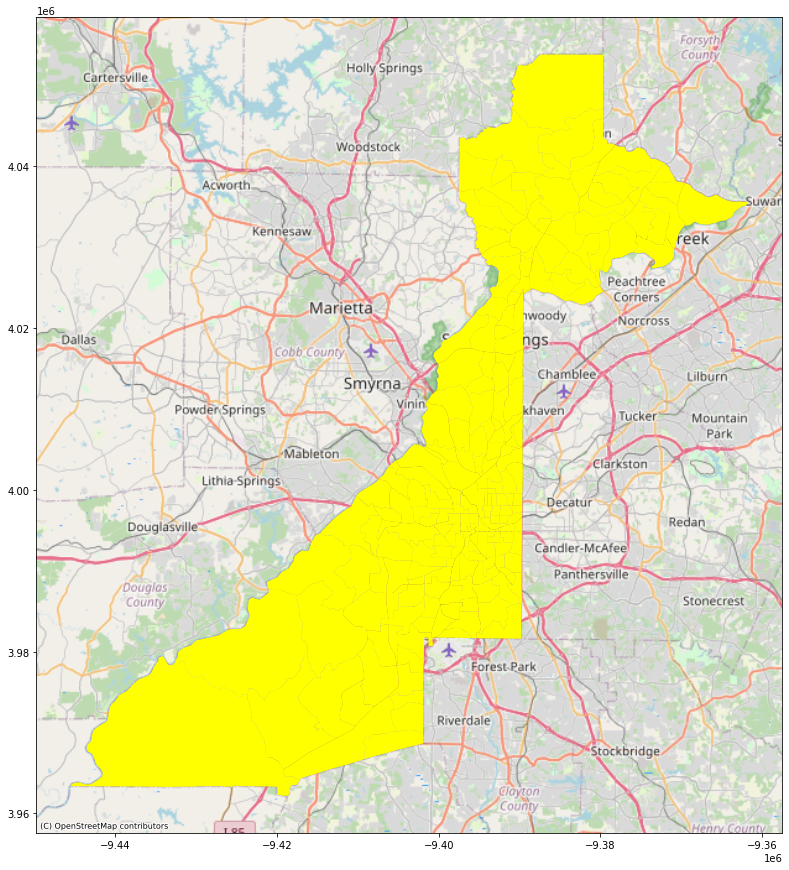

In [321]:
# Visualizing the food desert (my area of analysis)

ax = db.plot(figsize=(15, 15), alpha=0.2, color="k")
db.plot(ax=ax, color="yellow")
contextily.add_basemap(ax,source=contextily.providers.OpenStreetMap.Mapnik);
##source:https://contextily.readthedocs.io/en/latest/intro_guide.html

In [322]:
db.describe()

,median_age,total_pop,total_pop_white,total_pop_black,access_to_vehicle,hh_total,total_no_bachelor,median_hh_income,SNAP_hh,area_sqkm,pct_no_bachelor,pct_black,pct_white,pct_SNAP
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,36.241872,4953.039216,2229.887255,2186.039216,1851.243781,4953.039216,24.602941,66844.262376,1920.833333,6.783384,0.006608,0.476051,0.425161,0.397742
std,6.990583,2972.071006,2155.574353,2604.308540,1254.172915,2972.071006,30.511472,42419.178750,1098.389713,15.697038,0.014627,0.370914,0.328695,0.107856
min,12.400000,0.000000,0.000000,0.000000,200.000000,0.000000,0.000000,9815.000000,0.000000,0.090578,0.000000,0.000000,0.000000,0.000000
25%,32.400000,2590.500000,246.000000,545.000000,821.250000,2590.500000,0.000000,31153.250000,1091.250000,1.467469,0.000000,0.114780,0.067616,0.335617
50%,35.500000,4463.000000,1775.000000,1364.000000,1695.000000,4463.000000,16.000000,57066.500000,1834.000000,3.336304,0.004044,0.351557,0.474976,0.386730
75%,40.300000,6091.500000,3832.500000,2488.000000,2502.500000,6091.500000,33.250000,93487.000000,2565.500000,6.853089,0.008075,0.905903,0.731651,0.447258
max,67.900000,17958.000000,12255.000000,16075.000000,6555.000000,17958.000000,196.000000,200179.000000,6228.000000,185.117124,0.191176,1.000000,0.975895,0.808824


In [323]:
db.to_csv('fulton.csv', index=False)

In [324]:
! rm -f atlanta_tracts.gpkg
db.to_file("atlanta.gpkg", driver="GPKG")

## Kmeans Clustering (Elbow Method and Silhouette Scores)

In [325]:
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
import seaborn 
import pandas as pd
import geopandas 
import numpy
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

In [326]:
df = pd.read_csv('fulton.csv')
df.head()

,GEOID,geometry,median_age,total_pop,total_pop_white,total_pop_black,access_to_vehicle,hh_total,total_no_bachelor,median_hh_income,SNAP_hh,NAME,state,county,tract,area_sqkm,pct_no_bachelor,pct_black,pct_white,pct_SNAP
0,13121010400,"POLYGON ((-9445524.810000001 3963415.14, -9445...",37.5,8290.0,3877.0,3970.0,2815.0,8290.0,107.0,50294.0,2662.0,"Census Tract 104, Fulton County, Georgia",13,121,10400,185.117124,0.012907,0.478890,0.467672,0.321110
1,13121010512,"POLYGON ((-9412223.140000001 3972373.18, -9412...",28.3,6497.0,240.0,6061.0,2235.0,6497.0,15.0,30819.0,2472.0,"Census Tract 105.12, Fulton County, Georgia",13,121,10512,9.250057,0.002309,0.932892,0.036940,0.380483
2,13121010604,"POLYGON ((-9405103.470000001 3978853, -9405100...",35.3,2898.0,263.0,2342.0,990.0,2898.0,12.0,33133.0,1297.0,"Census Tract 106.04, Fulton County, Georgia",13,121,10604,4.741043,0.004141,0.808144,0.090752,0.447550
3,13121008301,"POLYGON ((-9403317.91 3997890.8, -9403309.23 3...",40.3,2556.0,58.0,2487.0,505.0,2556.0,55.0,27023.0,927.0,"Census Tract 83.01, Fulton County, Georgia",13,121,8301,2.628174,0.021518,0.973005,0.022692,0.362676
4,13121008102,"POLYGON ((-9406459.460000001 3995383.14, -9406...",37.8,6876.0,193.0,6353.0,1395.0,6876.0,42.0,24940.0,2693.0,"Census Tract 81.02, Fulton County, Georgia",13,121,8102,7.233104,0.006108,0.923938,0.028069,0.391652


In [327]:
# Selecting my cluster variables
df_Short = df[['pct_white', 'pct_black', 'pct_no_bachelor', 'SNAP_hh', 'median_age', 'median_hh_income']]

In [328]:
import sklearn.cluster as cluster

In [329]:
K=range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(df_Short)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [330]:
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

,Clusters,WSS
0,1,3.655204e+11
1,2,1.133627e+11
2,3,4.939958e+10
3,4,2.551773e+10
4,5,1.803265e+10
5,6,1.107913e+10
6,7,8.458827e+09
7,8,6.819266e+09
8,9,5.696522e+09
9,10,4.576498e+09


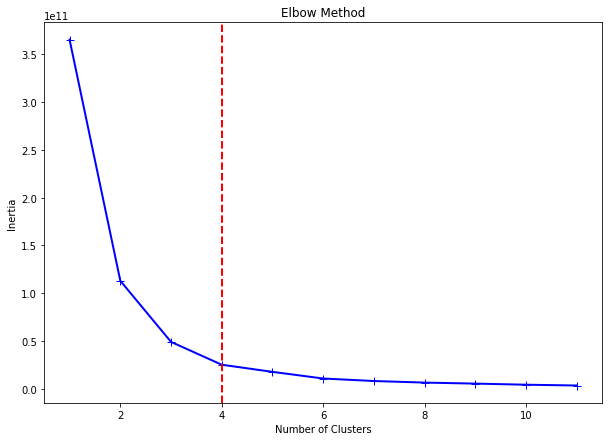

In [204]:
# Using elbow method to select the correct number of clusters

_ = plt.figure(figsize = (10,7))
_ = plt.plot(range(1,12), wss, linewidth = 2, color = 'blue', marker='+', markersize = 8)
_ = plt.title('Elbow Method', fontsize = 12)
_ = plt.xlabel('Number of Clusters',fontsize = 10)
_ = plt.ylabel('Inertia',fontsize = 10)

n_clusters = 4

_ = plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
_ = plt.show()

In [205]:
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.datasets import make_blobs
from pylab import rcParams
import numpy as np
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter

In [206]:
# Double-checking the correct number of c;lusters is chosen using silhouette scores

for i in range(2,13):
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=200).fit(df_Short).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(df_Short,labels,metric="euclidean",sample_size=1000,random_state=200)))

Silhouette score for k(clusters) = 2 is 0.6318406031651713
Silhouette score for k(clusters) = 3 is 0.6169908455360215
Silhouette score for k(clusters) = 4 is 0.613731279073885
Silhouette score for k(clusters) = 5 is 0.5917947190551015
Silhouette score for k(clusters) = 6 is 0.6004016618914658
Silhouette score for k(clusters) = 7 is 0.5751446924939094
Silhouette score for k(clusters) = 8 is 0.5570354583782787
Silhouette score for k(clusters) = 9 is 0.5333345136151703
Silhouette score for k(clusters) = 10 is 0.5509497316744304
Silhouette score for k(clusters) = 11 is 0.5593658264732276
Silhouette score for k(clusters) = 12 is 0.560320308751648


In [207]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=200).fit(df_Short) for k in range(2,13)]

silhouette_scores = [silhouette_score(df_Short, model.labels_)
                    for model in kmeans_per_k[0:]]
silhouette_scores

[0.6318406031651713,
 0.6169908455360216,
 0.6137312790738855,
 0.5917947190551022,
 0.600401661891466,
 0.5751446924939103,
 0.5570354583782806,
 0.5333345136151681,
 0.5509497316744281,
 0.5593658264732064,
 0.5603203087516221]

In [208]:
kmeans_per_k[0:]

[KMeans(n_clusters=2, random_state=200),
 KMeans(n_clusters=3, random_state=200),
 KMeans(n_clusters=4, random_state=200),
 KMeans(n_clusters=5, random_state=200),
 KMeans(n_clusters=6, random_state=200),
 KMeans(n_clusters=7, random_state=200),
 KMeans(random_state=200),
 KMeans(n_clusters=9, random_state=200),
 KMeans(n_clusters=10, random_state=200),
 KMeans(n_clusters=11, random_state=200),
 KMeans(n_clusters=12, random_state=200)]

k= 3   0.6169908455360216
k= 4   0.6137312790738855
k= 5   0.5917947190551022
k= 6   0.600401661891466


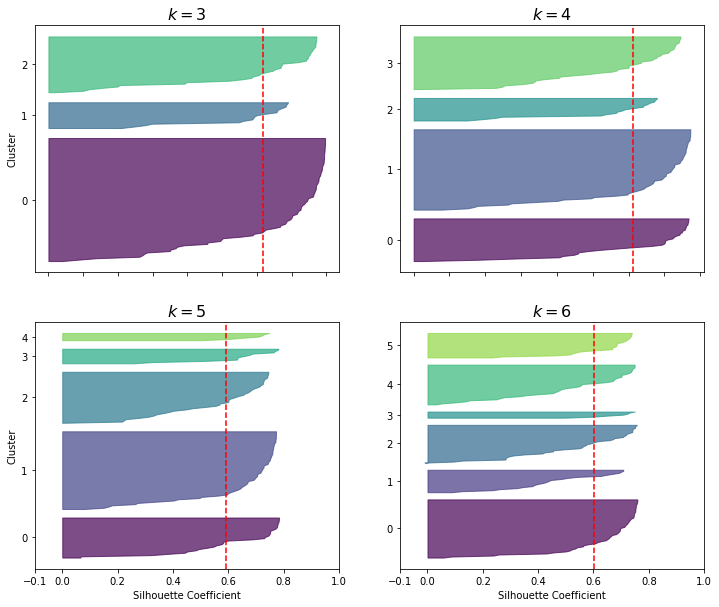

In [209]:
plt.figure(figsize=(12,10))

for k in (3,4,5,6):
    plt.subplot(2,2,k-2)
    
    y_pred = kmeans_per_k[k-1].labels_
    silhouette_coefficients = silhouette_samples(df_Short, y_pred)
    
    padding = len(df_Short)//30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        
        color = mpl.cm.viridis(i/k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs)//2)
        pos += len(coeffs) + padding
        
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3,5):
        plt.ylabel('Cluster')
        
    if k in(5,6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel('Silhouette Coefficient')
        
    else:
        plt.tick_params(labelbottom=False)
        
    plt.axvline(x=silhouette_scores[k-2], color='red', linestyle='--')
    print('k=',k,' ',silhouette_scores[k-2])
    plt.title('$k={}$'.format(k), fontsize=16)
    
plt.show()

## Clustering and Segmentation from Geographic Data Science with Python 

In [210]:
db = geopandas.read_file('atlanta.gpkg')
db.columns


/Users/marta/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  geom = geometries[i]


Index(['GEOID', 'median_age', 'total_pop', 'total_pop_white',
       'total_pop_black', 'access_to_vehicle', 'hh_total', 'total_no_bachelor',
       'median_hh_income', 'SNAP_hh', 'NAME', 'state', 'county', 'tract',
       'area_sqkm', 'pct_no_bachelor', 'pct_black', 'pct_white', 'pct_SNAP',
       'geometry'],
      dtype='object')

In [255]:
cluster_variables =  [
    'pct_white',          # Percent of tract population that is white
    'pct_black',          # Percent of tract population that is black
    'pct_no_bachelor',       # Percent of tract population with a Bachelors degree
    'pct_SNAP',
    'median_age',         # Median age of tract population
    'median_hh_income'    # Median household income
]

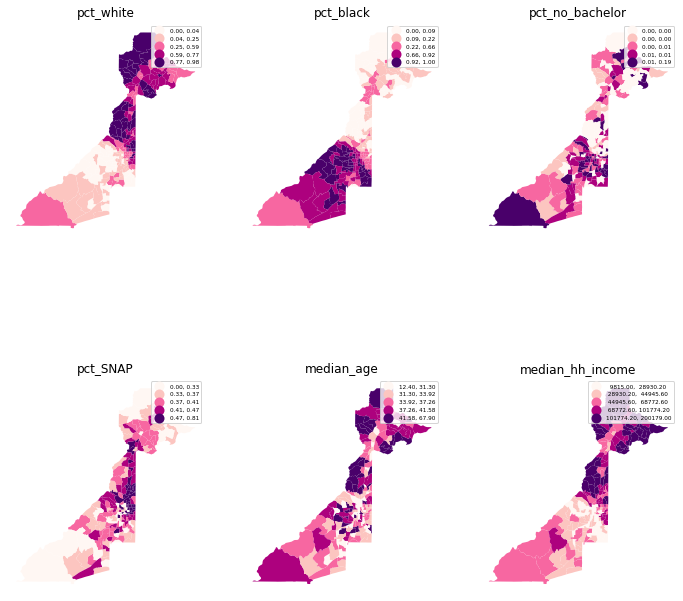

In [256]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='RdPu',legend=True,legend_kwds={'fontsize':'xx-small'})
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

## MEASURING VARIABLE CORRELATIONS

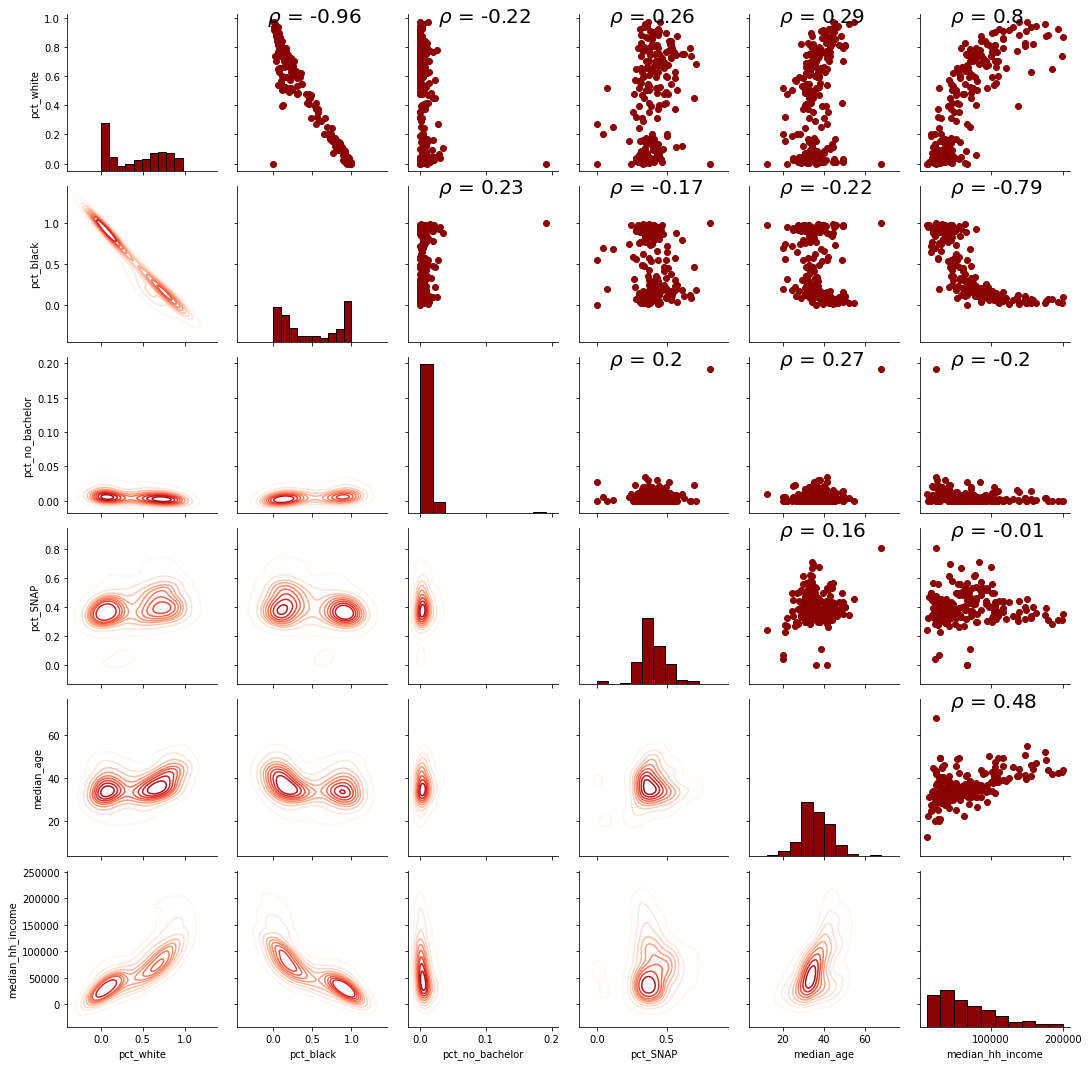

In [260]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)


grid = seaborn.PairGrid(db[cluster_variables])
# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(seaborn.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');
plt.savefig('PairGrid.png')
plt.show()

In [219]:
# Initialising KMeans instance
kmeans = KMeans(n_clusters=4)

In [220]:
numpy.random.seed(1234)
# Running K-Means algorithm
k4cls = kmeans.fit(db[cluster_variables])

In [221]:
k4cls.labels_

array([3, 0, 0, 0, 0, 3, 1, 3, 0, 3, 0, 3, 2, 0, 0, 3, 3, 1, 1, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 2, 3, 3, 3, 2, 0, 3, 3,
       3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3, 2, 3, 3, 2, 2, 0, 2,
       3, 3, 1, 2, 1, 2, 2, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 2, 0, 2, 2, 3, 3, 2, 2, 0, 2, 0, 0, 3, 1, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 1, 3, 3, 3, 2, 3, 1,
       3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 3, 0, 0, 2, 3, 0, 3, 2, 3, 2,
       2, 2, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 3, 2, 3, 2, 0, 2,
       1, 1, 2, 1, 1, 3, 0, 3, 0, 0, 3, 0, 0, 1, 2, 0, 0, 1, 1, 2, 2, 0,
       0, 3, 3, 1, 2, 1], dtype=int32)

In [222]:
k4cls.cluster_centers_

array([[1.27652093e-01, 8.21884220e-01, 1.03782879e-02, 3.82102881e-01,
        3.38344828e+01, 3.05794138e+04],
       [8.30623596e-01, 4.82216535e-02, 3.26863432e-03, 3.53007743e-01,
        4.45315789e+01, 1.62552000e+05],
       [7.65315908e-01, 1.01403055e-01, 3.47141468e-03, 4.24719416e-01,
        3.96150000e+01, 1.02675975e+05],
       [5.04012006e-01, 3.55829462e-01, 4.20831544e-03, 4.17249592e-01,
        3.48110668e+01, 6.51774746e+04]])

In [223]:
k4cls.inertia_

25301349274.203163

In [224]:
k4cls.n_iter_

4

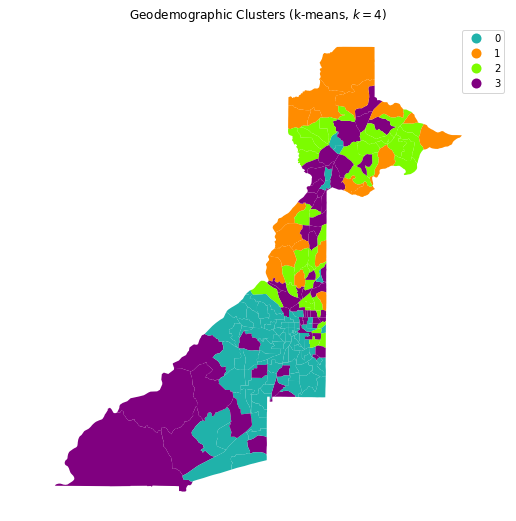

In [225]:
# Visualising clusters on the map

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmapTrial = ListedColormap(["lightseagreen", "darkorange", "lawngreen", "purple"])
db['k4cls'] = k4cls.labels_
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='k4cls', cmap=cmapTrial, categorical=True, legend=True, linewidth=0, ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.title(r'Geodemographic Clusters (k-means, $k=4$)')
plt.show()

In [226]:
# Grouping data table by cluster label and count observations
k4sizes = db.groupby('k4cls').size()
k4sizes


k4cls
0    87
1    19
2    40
3    58
dtype: int64

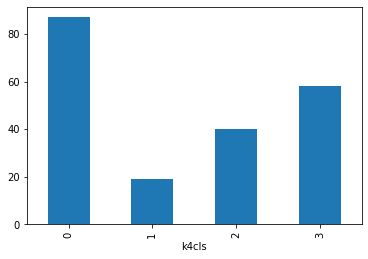

In [227]:
# cardinality
_ = k4sizes.plot.bar()

In [228]:
# Dissolve areas by Cluster, aggregate by summing, and keep column for area
areas = db.dissolve(by='k4cls', aggfunc='sum')['area_sqkm']
areas

k4cls
0    355.149451
1    243.458726
2    194.502643
3    590.699539
Name: area_sqkm, dtype: float64

<AxesSubplot:xlabel='k4cls'>

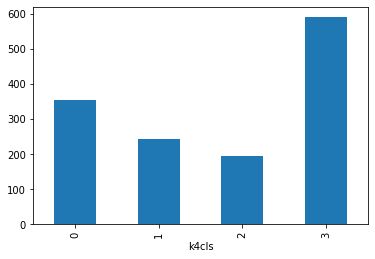

In [229]:
areas.plot.bar()

In [230]:
areas[3]/areas.sum()

0.4268645160860344

In [231]:
# Grouping table by cluster label
k4means = db.groupby('k4cls')[cluster_variables].mean()
k4means.T.round(3)

k4cls,0,1,2,3
pct_white,0.128,0.831,0.765,0.504
pct_black,0.822,0.048,0.101,0.356
pct_no_bachelor,0.010,0.003,0.003,0.004
pct_SNAP,0.382,0.353,0.425,0.417
median_age,33.834,44.532,39.615,34.811
median_hh_income,30579.414,162552.000,102675.975,65177.475


In [232]:
# Grouping table by cluster label, keep the variables used for clustering, and obtaining their descriptive summary
k4desc = db.groupby('k4cls')[cluster_variables].describe()
for cluster in k4desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k4desc.T[cluster].unstack())


	---------
	Cluster 0
                  count          mean          std          min           25%  \
pct_white          87.0      0.127652     0.157242     0.000000      0.021812   
pct_black          87.0      0.821884     0.199469     0.191483      0.777120   
pct_no_bachelor    87.0      0.010378     0.020931     0.000000      0.003814   
pct_SNAP           87.0      0.382103     0.102919     0.041799      0.331774   
median_age         87.0     33.834483     7.584881    12.400000     30.100000   
median_hh_income   87.0  30579.413793  9076.307694  9815.000000  24593.500000   

                           50%           75%           max  
pct_white             0.058947      0.160162      0.625127  
pct_black             0.908530      0.949826      1.000000  
pct_no_bachelor       0.006342      0.010154      0.191176  
pct_SNAP              0.372501      0.423992      0.808824  
median_age           33.300000     37.950000     67.900000  
median_hh_income  29276.000000  37519.00000